# Clustering redundant alignments from the database

In [93]:
import psycopg2
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import json

database = 'fomc'
conn = psycopg2.connect("dbname=" + database + " user=abarciauskas")
cur = conn.cursor()

nw_score_thresh = 0
year = 2007
cur.execute(
    "SELECT Doc1Id,Doc2Id,score FROM alignments WHERE Year = '" 
    + str(year) + "' AND nwscore >= " + str(nw_score_thresh)
)
redundancies = cur.fetchall()
len(redundancies)

477

## Step 1: Create the graph

The graph is comprised a list of edges (a vertex tuple) and a dictionary of vertices.

In [94]:
def create_graph(alignments):
    edges = [tuple([x[0],x[1]]) for x in alignments]
    vertices = {}
    for edge in edges:
        v1 = edge[0]
        v2 = edge[1]
        if v1 in vertices.keys():
            vertices[v1].add(v2)
        else:
            vertices[v1] = {v2}
        if v2 in vertices.keys():
            vertices[v2].add(v1)
        else:
            vertices[v2] = {v1}
    return [edges, vertices]

edges, vertices = create_graph(redundancies)
print len(vertices)
print len(edges)

346
477


In [50]:
# Testing
# vertices = {1: {5}, 2: {3,4}, 3: {2,4}, 4: {2,3}, 5: {1}}
# edges = [{1,5}, {2,3}, {2,4}, {3,2}, {3,4}]

In [95]:
# need to find disconnected graphs
graphs = []
unvisited = set(vertices.keys())

# Detect distinct graphs
while len(unvisited) > 0:
    # for every vertex, find all of its connected components and recurse on those vertices
    visited = []
    current_vertex = unvisited.pop()
    visited.append(current_vertex)
    stack_to_visit = list(vertices[current_vertex])
    while len(stack_to_visit) > 0:
        current_vertex = stack_to_visit.pop()
        current_adj_vtcs = vertices[current_vertex]
        if current_vertex not in visited: visited.append(current_vertex)
        if current_vertex in unvisited: unvisited.remove(current_vertex)        
        for v in current_adj_vtcs:
            if v not in visited:
                stack_to_visit.insert(0, v)
    graphs.append(visited)

print len(unvisited)
print len(visited)
print len(graphs)

0
2
107


In [96]:
# What is the distribution of these clusters?
cluster_sizes = [len(cluster) for cluster in graphs]
cluster_sizes[0:10]

[7, 8, 2, 2, 2, 10, 2, 2, 2, 7]

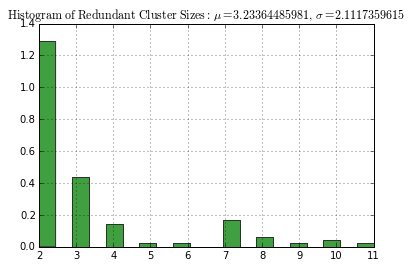

In [97]:
%matplotlib inline

# the histogram of the data
n, bins, patches = plt.hist(cluster_sizes, 20, normed=1, facecolor='green', alpha=0.75)
mu = np.mean(cluster_sizes)
sigma = np.std(cluster_sizes)
plt.title(r'$\mathrm{Histogram\ of\ Redundant\ Cluster\ Sizes:}\ \mu=' + str(mu) + ',\ \sigma=' + str(sigma) + '$')
# Note: there is a value lower, ths has cut some extremes
plt.grid(True)

plt.show()

In [108]:
# Filter clusters to those with at least 4 instances
threshold = 8
clusters = filter(lambda x: len(x) >= threshold, graphs)
len(clusters)

7

In [109]:
# Find cluster centroid
for cluster in clusters:
    degrees = [len(vertices[vertex]) for vertex in cluster]
    centroid_id = cluster[degrees.index(max(degrees))]
    cur.execute("SELECT Original FROM processed_documents WHERE Id = " + str(centroid_id))
    centroid = cur.fetchall()
    print centroid
    print ''

[('Attended portion of the meeting relating to the role of economic forecasts in policy communications.',)]

[('By unanimous vote, the Foreign_Currency_Directive was reaffirmed in the form 1.',)]

[('At its December meeting, the Federal_Open_Market_Committee( FOMC) decided to maintain its target for the federal funds rate at 5-1/4 percent.',)]

[('Readings on core inflation had been elevated, and the high level of resource utilization had the potential to sustain inflation pressures.',)]

[('Future policy adjustments would depend on the evolution of the outlook for both inflation and economic growth, as implied by incoming information.',)]

[('The_Committees predominant policy concern remained the risk that inflation would fail to moderate as expected.',)]

[('By notation vote completed on December 29, 2006, the Committee unanimously approved the minutes of the FOMC meeting held on December 12, 2006.',)]



In [110]:
cur.close()
conn.close()